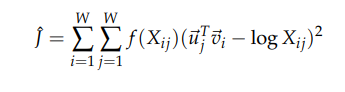

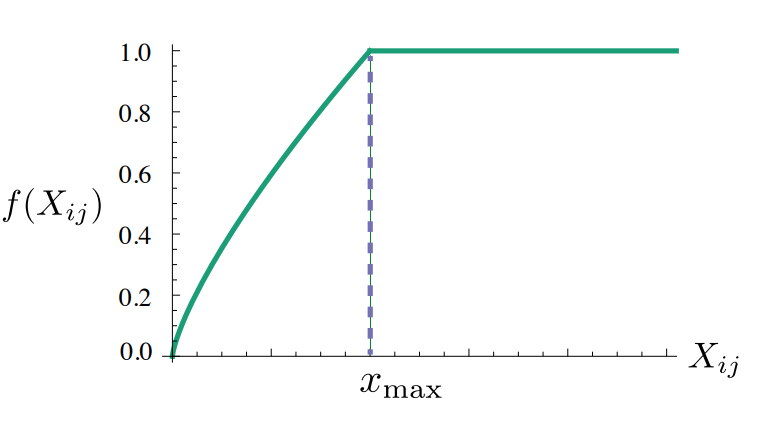

In [1]:
import torch
import tqdm
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
from itertools import combinations_with_replacement

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [5]:
def prepare_sequence(seq, w2i):
    idxs = list(map(lambda w: w2i[w] if w2i.get(w) is not None else w2i["<unk>"], seq))
    return Variable(torch.LongTensor(idxs)).to(device)

def prepare_word(word, w2i):
    return Variable(torch.LongTensor([w2i[word]]) if w2i.get(word) is not None else torch.LongTensor([w2i["<unk>"]])).to(device)

In [6]:
def get_batch(train_data, batch_size):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size

    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [7]:
corpus = list(nltk.corpus.gutenberg.sents('melville-moby_dick.txt'))[:500]
corpus = [[word.lower() for word in sent] for sent in corpus]

In [8]:
corpus[:2], len(corpus)

([['[', 'moby', 'dick', 'by', 'herman', 'melville', '1851', ']'],
  ['etymology', '.']],
 500)

In [9]:
word_count = Counter(flatten(corpus))
word_count.most_common()[:10]

[(',', 648),
 ('the', 533),
 ('.', 342),
 ('of', 299),
 ('a', 273),
 ('and', 258),
 ('in', 188),
 ('to', 182),
 ('--', 129),
 ('"', 120)]

In [10]:
vocab = list(set(flatten(corpus)))
vocab.append("<unk>")
vocab[:10], len(vocab)

(['order',
  'discover',
  'voyages',
  'belonged',
  'very',
  'n',
  'every',
  'miserable',
  'foundered',
  'harpooneer'],
 2608)

In [11]:
w2i = {"<unk>": 0}

for v in vocab:
    if w2i.get(v) == None:
        w2i[v] = len(w2i)

i2w = {v: k for k, v in w2i.items()}

In [12]:
window_size = 5
windows_ = [list(nltk.ngrams(["<dummy>"] * window_size + c + ["<dummy>"] * window_size, window_size * 2 + 1)) for c in corpus]
windows = flatten(windows_)
windows[:10]

[('<dummy>',
  '<dummy>',
  '<dummy>',
  '<dummy>',
  '<dummy>',
  '[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville'),
 ('<dummy>',
  '<dummy>',
  '<dummy>',
  '<dummy>',
  '[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville',
  '1851'),
 ('<dummy>',
  '<dummy>',
  '<dummy>',
  '[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville',
  '1851',
  ']'),
 ('<dummy>',
  '<dummy>',
  '[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville',
  '1851',
  ']',
  '<dummy>'),
 ('<dummy>',
  '[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville',
  '1851',
  ']',
  '<dummy>',
  '<dummy>'),
 ('[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville',
  '1851',
  ']',
  '<dummy>',
  '<dummy>',
  '<dummy>'),
 ('moby',
  'dick',
  'by',
  'herman',
  'melville',
  '1851',
  ']',
  '<dummy>',
  '<dummy>',
  '<dummy>',
  '<dummy>'),
 ('dick',
  'by',
  'herman',
  'melville',
  '1851',
  ']',
  '<dummy>',
  '<dummy>',
  '<dummy>',
  '<dummy>',
  '<dummy>'),
 ('<dummy>',
  '<dummy>',


In [13]:
window_data = []

for window in windows:
    for i in range(window_size * 2 + 1):
        if i == window_size or window[i] == "<dummy>":
            continue
        window_data.append((window[window_size], window[i]))

In [14]:
window_data[:20], len(window_data)

([('[', 'moby'),
  ('[', 'dick'),
  ('[', 'by'),
  ('[', 'herman'),
  ('[', 'melville'),
  ('moby', '['),
  ('moby', 'dick'),
  ('moby', 'by'),
  ('moby', 'herman'),
  ('moby', 'melville'),
  ('moby', '1851'),
  ('dick', '['),
  ('dick', 'moby'),
  ('dick', 'by'),
  ('dick', 'herman'),
  ('dick', 'melville'),
  ('dick', '1851'),
  ('dick', ']'),
  ('by', '['),
  ('by', 'moby')],
 88414)

In [15]:
Counter(flatten(window_data)).most_common()[:10]

[(',', 12310),
 ('the', 9590),
 ('of', 5530),
 ('a', 4992),
 ('and', 4766),
 ('in', 3434),
 ('to', 3402),
 ('.', 3210),
 ('that', 1984),
 ('-', 1846)]

In [16]:
X_ik_window_5 = Counter(window_data)
X_ik = {}
weighting_dict = {}

In [17]:
def weighting_fn(w_i, w_j, X_ik):
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1

    alpha = 0.75
    x_max = 100

    if x_ij < x_max:
        return (x_ij / x_max) ** alpha
    else:
        return 1

In [18]:
for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_window_5.get(bigram) is not None:
        co_occur = X_ik_window_5[bigram]
        X_ik[bigram] = co_occur + 1
        X_ik[(bigram[1], bigram[0])] = co_occur + 1

    weighting_dict[bigram] = weighting_fn(bigram[0], bigram[1], X_ik)
    weighting_dict[(bigram[1], bigram[0])] = weighting_fn(bigram[1], bigram[0], X_ik)

In [19]:
u = []
v = []
co_occurs = []
weights = []

for pair in window_data:
    u.append(prepare_word(pair[0], w2i).view(1, -1))
    v.append(prepare_word(pair[1], w2i).view(1, -1))

    try:
        co_occur = X_ik[pair]
    except:
        co_occur = 1

    co_occurs.append(torch.log(Variable(torch.FloatTensor([co_occur]))).view(1, -1).to(device))
    weights.append(Variable(torch.FloatTensor([weighting_dict[pair]])).view(1, -1).to(device))

train_data = list(zip(u, v, co_occurs, weights))

In [20]:
del u, v, weights, co_occurs

In [21]:
train_data[42]

(tensor([[1496]], device='cuda:0'),
 tensor([[280]], device='cuda:0'),
 tensor([[0.6931]], device='cuda:0'),
 tensor([[0.0532]], device='cuda:0'))

In [22]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.V = nn.Embedding(vocab_size, embedding_size)
        self.U = nn.Embedding(vocab_size, embedding_size)
        self.V_bias = nn.Embedding(vocab_size, 1)
        self.U_bias = nn.Embedding(vocab_size, 1)
        
        x = (2.0 / (vocab_size + embedding_size)) ** 0.5
        self.V.weight.data.uniform_(-x, x)
        self.U.weight.data.uniform_(-x, x) 
        self.V_bias.weight.data.uniform_(-x, x)
        self.U_bias.weight.data.uniform_(-x, x) 

    def forward(self, center_words, target_words, co_occurs, weights):
        center_embeds = self.V(center_words)
        target_embeds = self.U(target_words)

        center_bias = self.V_bias(center_words)
        target_bias = self.U_bias(target_words)

        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        loss = torch.sum(weights * ((inner_product + center_bias + target_bias - co_occurs) ** 2))

        return loss

In [23]:
epochs = 100
batch_size = 64
vocab_size = len(vocab)
embedding_size = 150
lr = 1e-3

In [24]:
net = Net(vocab_size, embedding_size).to(device)
opt = torch.optim.Adam(net.parameters(), lr)

In [25]:
def loop(net, batches):
    batch_losses = []
    net.train()

    for batch in batches:
        center_words, target_words, co_occurs, weights = zip(*batch)

        center_words = torch.cat(center_words)
        target_words = torch.cat(target_words)
        co_occurs = torch.cat(co_occurs)
        weights = torch.cat(weights)

        loss = net(center_words, target_words, co_occurs, weights)
        opt.zero_grad()
        loss.backward()
        opt.step()
        batch_losses.append(loss.item())

    return np.mean(batch_losses)

In [26]:
for epoch in range(epochs):
    loss = loop(net, get_batch(train_data, batch_size))

    if epoch % 10 == 0:
        print(f"epoch: {epoch} | loss: {loss:.4f}")

epoch: 0 | loss: 961.0485
epoch: 10 | loss: 4.1638
epoch: 20 | loss: 3.5855
epoch: 30 | loss: 2.7487
epoch: 40 | loss: 2.2214
epoch: 50 | loss: 1.8166
epoch: 60 | loss: 1.5924
epoch: 70 | loss: 1.4313
epoch: 80 | loss: 1.2727
epoch: 90 | loss: 1.1697


In [27]:
def get_similar_words(word, vocab):
    idx = prepare_word(word, w2i)
    v_input = net.V(idx) + net.U(idx)
    similar_words = []

    for i in range(len(vocab)):
        curr_word = vocab[i]
        if curr_word == word: continue

        curr_idx = prepare_word(curr_word, w2i)
        v_curr = net.V(curr_idx) + net.U(curr_idx)
        cosine_sim = F.cosine_similarity(v_input, v_curr)
        similar_words.append([curr_word, cosine_sim.item()])

    return sorted(similar_words, key=lambda x: x[1], reverse=True)[:10] 

In [29]:
random_word = random.choice(vocab)
print(random_word)
get_similar_words(random_word, vocab)

inmates


[['lay', 0.4469566345214844],
 ['little', 0.4408695101737976],
 ['maketh', 0.43701085448265076],
 ['carthage', 0.43614330887794495],
 ['before', 0.4075230658054352],
 ['sounds', 0.40598630905151367],
 ['tail', 0.4059750437736511],
 ['crossed', 0.3990029990673065],
 ['floating', 0.39013582468032837],
 ['then', 0.3823569715023041]]